<a href="https://colab.research.google.com/github/harikuttan7136/ELL888-Minor-Graph-learning/blob/main/Graph_learning_categorical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import sys
import math
from sklearn.model_selection import train_test_split
np.set_printoptions(threshold=sys.maxsize)
from sklearn.metrics.pairwise import euclidean_distances

In [3]:
from google.colab import files
uploaded = files.upload()

Saving australian (1).dat to australian (1).dat


In [4]:
import io
df = pd.read_csv(io.BytesIO(uploaded['australian (1).dat']),header=None,sep=" ")

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [6]:
X=df.drop(14,axis=1).to_numpy()
Y=df[14].to_numpy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [8]:
# finding the categorical columns k is the number of nique values to determine if categorical or not
def findCategoricalIntegerColumns(X,k=5):
  i=0
  categorical=[]
  integer=[]
  for j in X.T:
    unique_values=np.unique(j).shape[0]
    if(unique_values<=k):
      categorical.append(i)
    else:
      flag=0
      for z in j:
        if int(z)!=z:
          flag=1
          break
      if flag==0:
        integer.append(i)
    i+=1
  return categorical,integer
    

In [9]:
categorical_cols,integer_cols=findCategoricalIntegerColumns(X_train,k=5)

In [10]:
#printing the categorical cols detected
categorical_cols

[0, 3, 7, 8, 10, 11]

In [11]:
#integer cols detected
integer_cols

[4, 5, 9, 12, 13]

In [12]:
#min max normalisation for the data note distance with categorical values doesn't change even if we normalise them
def minmaxnormalize(X):
  max=np.max(X,axis=0)
  min=np.min(X,axis=0)
  return [(X-min)/(max-min),max,min]

In [13]:
X_train,max,min=minmaxnormalize(X_train)

In [14]:
X_train=X_train[:20,:]
y_train=y_train[:20]

In [15]:
# distance calculation for categorical data with hamming distance and minowski distance for integer values and euclidean distance for real valued variables
def distance_metric(x,y,categorical_cols,integer_cols):
  n=len(x)
  hamming=0
  minowski_p1=0
  euclidean=0
  distance=0
  for i in range(n):
    if i in categorical_cols:
      hamming+=(1 if x[i]==y[i] else 0)
    elif i in integer_cols:
      minowski_p1+=abs(x[i]-y[i])
    else:  
      euclidean+=(x[i]-y[i])**2
  distance+=hamming+minowski_p1+math.sqrt(euclidean)
  return distance/n

In [16]:
#calculating the pairwise distance using the above distance function
n=len(X_train)
D=np.zeros((n,n))
for i in range(n):
  for j in range(i+1,n):
    D[i][j]+=distance_metric(X_train[i],X_train[j],categorical_cols,integer_cols)

In [17]:
# guassian weight calculation using E and D
def gaussian_weight(E,D,var=1):
  return np.multiply(E,np.exp(-D)/(2*var))

In [18]:
# kNN graph learning which returns edge matrix E
def kNN_graph(D,k=5):
  n=D.shape[0]
  E=np.zeros((n,n))
  for i in range(n):
    dist=D[i]
    idx = np.argpartition(dist, k)
    count=0
    for j in idx:
      if i!=j and i in (np.argpartition(D[j], k)):
        E[i][j]=1
        count+=1
      if count==k:
        break
  return E

In [25]:
E=kNN_graph(D,k=3)

In [26]:
E.shape

(20, 20)

In [21]:
W=gaussian_weight(E,D,var=1)

In [22]:
np.mean(D)

0.1621665997885623

In [27]:
# Finding the graph with just euclidean distance for all features
dfX=pd.DataFrame(X_train)
Ddf=euclidean_distances(dfX,dfX)
Edf=kNN_graph(Ddf,k=3)

In [24]:
np.mean(Ddf)

1.3936993787643386

In [72]:
y_train

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])

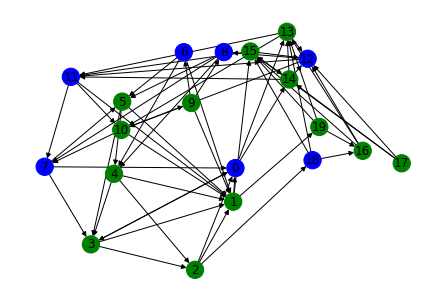

In [28]:
# plotting the graph predicted according to the algorithm
import networkx as nx 
import matplotlib.pyplot as plt
G = nx.DiGraph()
color_map=[]
Y_tot=y_train.copy()
for i in range(len(Y_tot)):
  G.add_node(i)
  if Y_tot[i]==1:
    color_map.append("blue")
  else:
    color_map.append("green")
for i in range(E.shape[0]): 
 for j in range(E.shape[1]): 
   if E[i][j] == 1: 
      G.add_edge(i,j) 
nx.draw( G ,node_color=color_map,with_labels=True) 
plt.show() 


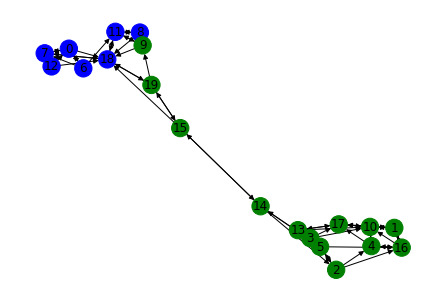

In [29]:
#plotting graph learned with euclidean distance for all features
G = nx.DiGraph()
color_map=[]
Y_tot=y_train.copy()
for i in range(len(Y_tot)):
  G.add_node(i)
  if Y_tot[i]==1:
    color_map.append("blue")
  else:
    color_map.append("green")
for i in range(Edf.shape[0]): 
 for j in range(Edf.shape[1]): 
   if Edf[i][j] == 1: 
      G.add_edge(i,j) 
nx.draw( G ,node_color=color_map,with_labels=True) 
plt.show() 